# Facial Emotion Recognition with PyTorch

This notebook demonstrates how to build, train, and evaluate a Convolutional Neural Network (CNN) for facial emotion recognition using PyTorch. The model is trained to classify facial expressions into seven emotion categories: Angry, Disgust, Fear, Happy, Neutral, Sad, and Surprise.

## Overview

The notebook covers the following steps:

1. Data loading and preprocessing
2. Exploratory data analysis
3. Model architecture design
4. Training the model with appropriate loss functions and optimizers
5. Evaluating model performance
6. Saving the trained model for inference

## Requirements

- Python 3.6+
- PyTorch
- torchvision
- NumPy
- Matplotlib
- A dataset of facial emotion images (organized in folders by emotion class)


## Import Libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

## Data Preparation

We'll use a dataset of facial emotion images organized in folders by emotion class. The dataset is split into training and validation sets.

In [10]:
# Setting up directory paths for training and validation datasets
train_dir = 'archive/images/train'
test_dir = 'archive/images/validation'

## Data Preprocessing and Loading

We'll apply the following preprocessing steps to our images:

1. Convert images to grayscale (emotions can be recognized without color)
2. Resize images to 48x48 pixels (standard size for facial emotion recognition)
3. Apply data augmentation to the training set (rotation, flipping)
4. Convert to PyTorch tensors and normalize to range [-1, 1]

Data augmentation helps prevent overfitting and improves model generalization.

In [ ]:
height, width = 48, 48

# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((height, width)),           # Resize to 48x48 pixels
    transforms.RandomRotation(20),                # Random rotation for augmentation
    transforms.RandomHorizontalFlip(),           # Random horizontal flip for augmentation
    transforms.ToTensor(),                        # Convert to tensor (scales pixels to [0,1])
    transforms.Normalize(mean=[0.5], std=[0.5]), # Normalize to range [-1, 1]
])

# Validation set transformations (no augmentation)
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((height, width)),           
    transforms.ToTensor(),                        
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset objects
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=test_dir, transform=val_transform)

# Create data loaders with batch size of 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Exploratory Data Analysis

Let's explore the dataset to understand its composition. We'll count the number of images in each emotion class for both training and validation sets. This will help us identify any class imbalance issues that might affect model training.

In [ ]:
# Function to count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(train_dir):  
        class_path = os.path.join(directory, class_name)
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = num_images
    return class_counts

train_class_counts = count_images_per_class(train_dir)
total_train_images = sum(train_class_counts.values())
print("Number of images per class in training data:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")
print(f"Total training images: {total_train_images}")

test_class_counts = count_images_per_class(test_dir)
total_test_images = sum(test_class_counts.values())
print("\nNumber of images per class in test data:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")
print(f"Total test images: {total_test_images}")

Number of images per class in training data:
angry: 3993
disgust: 436
fear: 4103
happy: 7164
neutral: 4982
sad: 4938
surprise: 3205
Total training images: 28821

Number of images per class in test data:
angry: 960
disgust: 111
fear: 1018
happy: 1825
neutral: 1216
sad: 1139
surprise: 797
Total test images: 7066


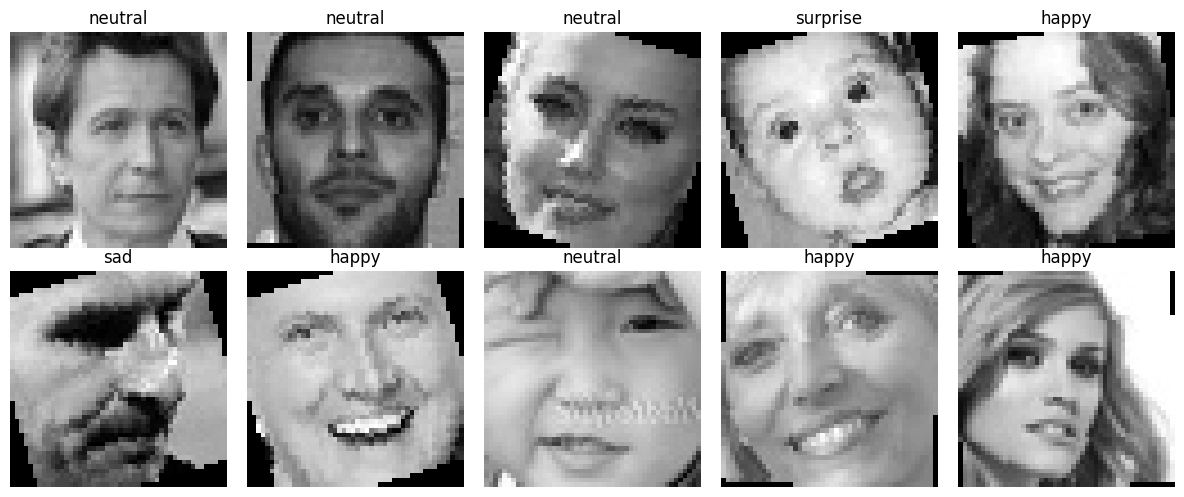

In [5]:
sample_images, sample_labels = next(iter(train_loader))

num_samples = 10
class_labels = train_dataset.classes


fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(num_samples):
    img = sample_images[i].squeeze().numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(class_labels[sample_labels[i]])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Model Architecture

We'll define a Convolutional Neural Network (CNN) architecture for facial emotion recognition. The model consists of:

1. Three convolutional blocks, each with:
   - Convolutional layer
   - LeakyReLU activation
   - Batch normalization
   - Max pooling

2. Fully connected layers:
   - Flatten layer
   - Dense layer with LeakyReLU activation
   - Dropout for regularization
   - Output layer with 7 units (one for each emotion class)

This architecture is designed to extract hierarchical features from facial images and classify them into emotion categories.

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary
from torchsummary import summary

class SimpleCNNModel(nn.Module):
    def __init__(self, leaky_slope=0.01):
        super(SimpleCNNModel, self).__init__()
        # 1st Conv Block: 16 filters
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(0.25)
        )
        # 2nd Conv Block: 64 filters
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(36),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(0.25)
        )
        # 3rd Conv Block: 64 filters
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=36, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(0.25)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.leaky_relu = nn.LeakyReLU(negative_slope=leaky_slope)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 7)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = SimpleCNNModel(leaky_slope=0.01)

# Training parameters
initial_lr = 0.001
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=initial_lr,
#     momentum=0.9,
#     nesterov=True,
#     weight_decay=0.0001
# )

optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=0.001)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10000, eta_min=initial_lr * 0.01)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.2,
#     patience=3
# )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(1, 48, 48), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
              ReLU-2           [-1, 64, 48, 48]               0
       BatchNorm2d-3           [-1, 64, 48, 48]             128
         MaxPool2d-4           [-1, 64, 24, 24]               0
           Dropout-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
              ReLU-7          [-1, 128, 24, 24]               0
       BatchNorm2d-8          [-1, 128, 24, 24]             256
         MaxPool2d-9          [-1, 128, 12, 12]               0
          Dropout-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
      BatchNorm2d-13          [-1, 256, 12, 12]             512
        MaxPool2d-14            [-1, 25

## Improved Model Architecture

Now let's define an improved CNN model with several enhancements:

1. Deeper architecture with additional convolutional layers
2. Skip connections inspired by ResNet architecture
3. Increased dropout for better regularization
4. Bottleneck architecture in fully connected layers

These improvements help the model learn more complex features and reduce overfitting.

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary
from torchsummary import summary

class ImprovedCNNModel(nn.Module):
    def __init__(self, leaky_slope=0.01, dropout_rate=0.3):
        super(ImprovedCNNModel, self).__init__()
        # 1st Conv Block: Increased filters, added second conv layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_rate)
        )
        
        # 2nd Conv Block: Deeper architecture
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_rate)
        )
        
        # 3rd Conv Block: Even deeper
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_rate)
        )
        
        # Added residual-style skip connection
        self.skip_conv = nn.Conv2d(16, 64, kernel_size=1, stride=4)
        
        # Improved FC layers with bottleneck architecture
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 6 * 6, 1024),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=leaky_slope),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(512, 7)
        )
        
    def forward(self, x):
        # Main path
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        
        # Skip connection
        skip = self.skip_conv(conv1_out)
        combined = conv3_out + skip
        
        # Flatten and FC layers
        out = combined.view(combined.size(0), -1)
        out = self.fc_layers(out)
        return F.log_softmax(out, dim=1)

# Hyperparameters
model = ImprovedCNNModel(leaky_slope=0.01, dropout_rate=0.3)

# Improved optimizer settings
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# Learning rate scheduler with warmup
from torch.optim.lr_scheduler import OneCycleLR

# Calculate total steps (epochs * batches_per_epoch)
total_steps = num_epochs * len(train_loader)

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,
    total_steps=total_steps,
    pct_start=0.3,  # 30% of training for warmup
    div_factor=25,  # initial_lr = max_lr/25
    final_div_factor=1000  # final_lr = initial_lr/1000
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(1, 48, 48), device=str(device))

# Modified training loop
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    return running_loss / len(train_loader), 100. * correct / total

## Training with Class Weighting

Now we'll train the model with class weighting to handle the imbalanced dataset. Class weighting assigns higher importance to underrepresented classes during training.

We'll also implement:
1. Multi-GPU training support
2. Early stopping to prevent overfitting
3. Learning rate scheduling
4. Model checkpointing to save the best model

In [7]:
print(torch.version.cuda)

12.8


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training")
    model = nn.DataParallel(model)

    
class_weights = torch.tensor([
    7.22,   # Angry
    66.10,  # Disgust 
    7.02,   # Fear
    4.02,   # Happy
    5.78,   # Neutral
    5.84,   # Sad
    9.00    # Surprise
], device=device)


criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total
    
    #Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:  
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
os.makedirs('models', exist_ok=True)

if isinstance(model, nn.DataParallel): 
    torch.save(model.module.state_dict(), 'models/model2.pth')
else:
    torch.save(model.state_dict(), 'models/model.pth')

print(f"Model saved to models/model.pth")


Using device: cuda


C:\Users\arnav\AppData\Local\Temp\ipykernel_14688\1143949952.py:55: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  train_loss += loss.item() * inputs.size(0)


KeyboardInterrupt: 

## Model Saving

After training, we save the best model to disk for later use in inference. The model is saved in PyTorch's native format (.pth).
This saved model can be loaded in other applications, such as our real-time emotion detection driver.